### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle

import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy as sc
import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

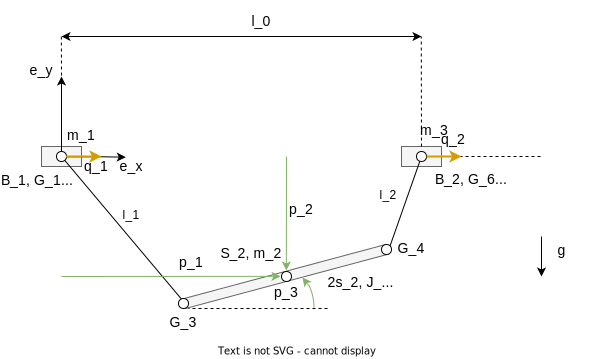

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas) ##:T
meas_states_d = st.time_deriv(meas_states, meas_states) ##:T

st.make_global(meas_states, meas_states_d)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

aa.T := [a₁  a₂  a₃  a₄]

---

ttheta.T := [p₁  p₂  p₃  q₁  q₂]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  q̈₁  q̈₂]

---

tthetaddd.T := [p⃛₁  p⃛₂  p⃛₃  q⃛₁  q⃛₂]

---

tthetadddd.T := [p⃜₁  p⃜₂  p⃜₃  q⃜₁  q⃜₂]

---

meas_states.T := [pm₁  pm₂  pm₃  qm₁  qm₂]

---

meas_states_d.T := [pṁ₁  pṁ₂  pṁ₃  qṁ₁  qṁ₂]

---

QQ.T := [Q₁  Q₂  Q₃  Q₄  Q₅]

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

# rope vectors
rope1 = (G3 - S1)
rope2 = (G4 - S3)

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G3 := ⎡p₁ - s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ - s₂⋅sin(p₃)⎦

---

G4 := ⎡p₁ + s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ + s₂⋅sin(p₃)⎦

---

(Sd1, Sd2, Sd3) := ⎛⎡q̇₁⎤  ⎡ṗ₁⎤  ⎡q̇₂⎤⎞
⎜⎢  ⎥, ⎢  ⎥, ⎢  ⎥⎟
⎝⎣0 ⎦  ⎣ṗ₂⎦  ⎣0 ⎦⎠

---

# Initial values

In [6]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    mod, eqns, ttau, flat_tau1_control, flat_tau2_control, flat_tau3_control, flat_tau4_control = pickle.load(pfile)

In [7]:
# resubstitute the rope lengths:
mod.eqns = eqns.subz([l1, l2], [sp.sqrt((rope1.T*rope1)[0]), sp.sqrt((rope2.T*rope2)[0])])

In [8]:
mod.eqns

⎡                                                                           τ₃
⎢                                                       m₂⋅p̈₁ - ─────────────
⎢                                                                  ___________
⎢                                                                 ╱           
⎢                                                               ╲╱  (p₂ - s₂⋅s
⎢                                                                             
⎢                                                                             
⎢                                                   g⋅m₂ + m₂⋅p̈₂ - ──────────
⎢                                                                     ________
⎢                                                                    ╱        
⎢                                                                  ╲╱  (p₂ - s
⎢                                                                             
⎢                 s₂⋅τ₃⋅(p₂ - s₂⋅sin(p₃))⋅cos(p₃)   

In [9]:
mod.tau = ttau

In [10]:
mod.calc_state_eq(force_recalculation=True)

In [11]:
mod.f

⎡ṗ₁⎤
⎢  ⎥
⎢ṗ₂⎥
⎢  ⎥
⎢ṗ₃⎥
⎢  ⎥
⎢q̇₁⎥
⎢  ⎥
⎢q̇₂⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢-g⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎣0 ⎦

In [12]:
mod.g

⎡0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢                         p₁ - q₁ - s₂⋅cos(p₃)                                
⎢0   0   ─────────────────────────────────────────────────────  ──────────────
⎢              _____________________________________

In [13]:
sys_params = list(dict(J2=0.004553475, g=9.81, l0=0.3, m1=0.45, m2=0.557, m3=0.45, s2=0.15).items()) ##:

sys_params := [('J2', 0.004553475),
 ('g', 9.81),
 ('l0', 0.3),
 ('m1', 0.45),
 ('m2', 0.557),
 ('m3', 0.45),
 ('s2', 0.15)]

---

In [14]:
eqns.subz0(tthetadd)

⎡                                               τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃)
⎢                                             - ──────────────────────────────
⎢                                                              l₂             
⎢                                                                             
⎢                                                         τ₄⋅(p₂ + s₂⋅sin(p₃))
⎢                                                  g⋅m₂ - ────────────────────
⎢                                                                  l₂         
⎢                                                                             
⎢  s₂⋅τ₄⋅(p₂ + s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⋅sin(p₃
⎢- ─────────────────────────────── + ─────────────────────────────────────────
⎢                 l₂                                     l₂                   
⎢                                                                             
⎢                                                   

In [15]:
# determine a symetrical equilibrium:
# TODO: woher Wahl von ttau?
eqlbr_conditions = [(q1, 0), (p1, 0.15), (p2, -0.4), (p3, 0), (tau1, 0), (tau2, 0), (tau3, tau4)] ##:

res = ((mod.eqns.subz0(tthetadd)).subs(eqlbr_conditions)).subs(sys_params) ##:

---

res := ⎡              q₂⋅τ₄               ⎤
⎢         ───────────────          ⎥
⎢            ____________          ⎥
⎢           ╱   2                  ⎥
⎢         ╲╱  q₂  + 0.16           ⎥
⎢                                  ⎥
⎢              0.4⋅τ₄              ⎥
⎢1.0⋅τ₄ + ─────────────── + 5.46417⎥
⎢            ____________          ⎥
⎢           ╱   2                  ⎥
⎢         ╲╱  q₂  + 0.16           ⎥
⎢                                  ⎥
⎢                   0.06⋅τ₄        ⎥
⎢    -0.15⋅τ₄ + ───────────────    ⎥
⎢                  ____________    ⎥
⎢                 ╱   2            ⎥
⎢               ╲╱  q₂  + 0.16     ⎥
⎢                                  ⎥
⎢                0                 ⎥
⎢                                  ⎥
⎢             -q₂⋅τ₄               ⎥
⎢         ───────────────          ⎥
⎢            ____________          ⎥
⎢           ╱   2                  ⎥
⎣         ╲╱  q₂  + 0.16           ⎦

---

In [16]:
symbs = list(res.s) ##:
sol = sp.solve(res, symbs, dict=True) ##:

---

---

In [17]:
ttheta0 = st.to_np(ttheta.subs(eqlbr_conditions).subs(q2,0)).squeeze() ##:

uu0 = st.to_np(ttau.subs(eqlbr_conditions).subs(tau4, -2.732085)).squeeze()##:

ttheta0 := array([ 0.15, -0.4 ,  0.  ,  0.  ,  0.  ])

---

uu0 := array([ 0.      ,  0.      , -2.732085, -2.732085])

---

# Trajectory planning
The parametrization of $\tau_2$ determines the highest required order $N_i$ of the flat output's derivatives. For each component of the flat output a trajectory $y_i$ can be chosen with a polynomial order of $\alpha_i = 2 N_i + 1$ in compliance with the system's initial values.

In [92]:
T0, T1 = 0, 10
p10, p20, p30, q10 = ttheta0[:-1] ##:
q10 = q10 + 0.05
p1e, p2e, p3e, q1e = ttheta0[:-1] - 0.3 ##:
p3e = -0.2
# polynoms of order 9 (boundary conditions until 4th derivative) for p_i
p1_traj = st.condition_poly(t, (T0, p10, 0, 0, 0, 0), (T1, p1e, 0, 0, 0, 0)) ##:
p2_traj = st.condition_poly(t, (T0, p20, 0, 0, 0, 0), (T1, p2e, 0, 0, 0, 0)) ##:
p3_traj = st.condition_poly(t, (T0, p30, 0, 0, 0, 0), (T1, p3e, 0, 0, 0, 0)) ##:
# polynoms of order 5 (boundary conditions until 2nd derivative) for q_1
q1_traj = st.condition_poly(t, (T0, q10, 0, 0), (T1, q1e, 0, 0)) ##:

---

---

---

---

---

---

Substitution of $\mathbf{y}$ with trajectories into control inputs

In [93]:
flat_quantities = [p1, p2, p3, q1,
                   pdot1, pdot2, pdot3, qdot1, 
                   pddot1, pddot2, pddot3, qddot1,
                   pdddot1, pdddot2, pdddot3, 
                   pddddot1, pddddot2, pddddot3]

flat_quant_subs = [p1_traj, p2_traj, p3_traj, q1_traj,
                   p1_traj.diff(t), p2_traj.diff(t), p3_traj.diff(t), q1_traj.diff(t),
                   p1_traj.diff(t, 2), p2_traj.diff(t, 2), p3_traj.diff(t, 2), q1_traj.diff(t, 2),
                   p1_traj.diff(t, 3), p2_traj.diff(t, 3), p3_traj.diff(t, 3),
                   p1_traj.diff(t, 4), p2_traj.diff(t, 4), p3_traj.diff(t, 4)]


In [94]:
tau1_traj = flat_tau1_control.subz(flat_quantities, flat_quant_subs)
tau2_traj = flat_tau2_control.subz(flat_quantities, flat_quant_subs)
tau3_traj = flat_tau3_control.subz(flat_quantities, flat_quant_subs)
tau4_traj = flat_tau4_control.subz(flat_quantities, flat_quant_subs)

# verify that only constant system parameters and the time quantity are included
set([*tau1_traj.s, *tau2_traj.s, *tau3_traj.s, *tau4_traj.s]) ##:

---

In [95]:
# replace system parameters with numerical values
tau1_traj_num = tau1_traj.subs(sys_params)
tau2_traj_num = tau2_traj.subs(sys_params)
tau3_traj_num = tau3_traj.subs(sys_params)
tau4_traj_num = tau4_traj.subs(sys_params)

In [96]:
# create callable function from symbolic expressions:
tau1_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau1_traj_num)
tau2_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau2_traj_num)
tau3_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau3_traj_num)
tau4_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau4_traj_num)

# Simulation model

In [97]:
mod.xx

⎡p₁⎤
⎢  ⎥
⎢p₂⎥
⎢  ⎥
⎢p₃⎥
⎢  ⎥
⎢q₁⎥
⎢  ⎥
⎢q₂⎥
⎢  ⎥
⎢ṗ₁⎥
⎢  ⎥
⎢ṗ₂⎥
⎢  ⎥
⎢ṗ₃⎥
⎢  ⎥
⎢q̇₁⎥
⎢  ⎥
⎣q̇₂⎦

In [98]:
sim = st.SimulationModel(mod.f, mod.g, mod.xx, model_parameters=sys_params)

In [99]:
# control forces for stabilizing equilbrium
uu1 = npy.array([  0  ,   0.  , -2.732085, -2.732085])
def composite_force(x, t):
    # friction constants
    di = 10
    dissipation1 = -di*x[8]
    dissipation2 = -di*x[9]
    control_force = 0
    
    forces = uu1 #+ [dissipation1, dissipation2, 0.0, 0.0]
    return forces

# control forces for driving feed forward trajectories
def feed_forward_traj(x, t):
    if t < 1e-2:
        forces = uu1        
    elif t < 9.99:
        u1 = tau1_traj_func(t, *x)
        u2 = tau2_traj_func(t, *x)
        u3 = tau3_traj_func(t, *x)
        u4 = tau4_traj_func(t, *x)
        forces = [u1, u2, u3, u4]
    else:
        u1 = tau1_traj_func(9.99, *x)
        u2 = tau2_traj_func(9.99, *x)
        u3 = tau3_traj_func(9.99, *x)
        u4 = tau4_traj_func(9.99, *x)
        forces = [u1, u2, u3, u4]
    return forces

rhs = sim.create_simfunction(controller_function=feed_forward_traj)

In [100]:
xx0 = npy.concatenate((ttheta0, ttheta0*0)) ##:

xx0 := array([ 0.15, -0.4 ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ])

---

In [101]:
tt = npy.linspace(0, 20, 2000)

In [102]:
# solve_ivp is more modern, but the signature of rhs is taylored towards odeint
res = sc_integrate.odeint(rhs, xx0, tt) ##:i

/home/kwrede/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


info(res) := "<class 'numpy.ndarray'> with shape: (2000, 10)"

---

In [103]:
mod.tt

⎡p₁⎤
⎢  ⎥
⎢p₂⎥
⎢  ⎥
⎢p₃⎥
⎢  ⎥
⎢q₁⎥
⎢  ⎥
⎣q₂⎦

In [104]:
res[0, :]

array([ 0.15, -0.4 ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ])

In [105]:
res[100, :]

array([ 1.49732811e-01, -3.96166082e-01, -3.20648707e-04,  6.32675885e-02, -6.41696912e-02, -1.23145397e-03, -1.91174094e-02, -1.99762185e-03, -5.90912658e-02,  5.57028877e-02])

In [106]:
# numeric trajs
p1_num = st.expr_to_func(t, p1_traj)
p2_num = st.expr_to_func(t, p2_traj)
p3_num = st.expr_to_func(t, p3_traj)
q1_num = st.expr_to_func(t, q1_traj)
# deviation of simulated and reference trajs
err_trajp1 = npy.mean(abs(res[:1000, 0] - p1_num(tt[tt<10]))) ##:
err_trajp2 = npy.mean(abs(res[:1000, 1] - p2_num(tt[tt<10]))) ##:
err_trajp3 = npy.mean(abs(res[:1000, 2] - p3_num(tt[tt<10]))) ##:
err_trajq1 = npy.mean(abs(res[:1000, 3] - q1_num(tt[tt<10]))) ##:

---

---

---

---

In [107]:
ttau = list(map(feed_forward_traj, res[1:1500, :] ,tt[1:1500]))
ttau1, ttau2, ttau3, ttau4 = zip(*ttau)

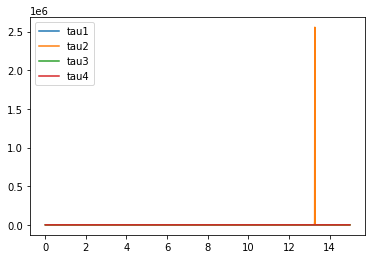

In [108]:
plt.plot(tt[1:1500], ttau1, label="tau1")
plt.plot(tt[1:1500], ttau2, label="tau2")
plt.plot(tt[1:1500], ttau3, label="tau3")
plt.plot(tt[1:1500], ttau4, label="tau4")
plt.legend()

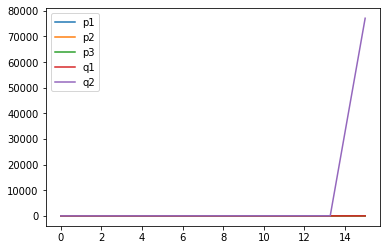

In [109]:
plt.plot(tt[:1500], res[:1500, 0], label="p1")
plt.plot(tt[:1500], res[:1500, 1], label="p2")
plt.plot(tt[:1500], res[:1500, 2], label="p3")
plt.plot(tt[:1500], res[:1500, 3], label="q1")
plt.plot(tt[:1500], res[:1500, 4], label="q2")
plt.legend()

In [39]:
joint_pos_expr = st.col_stack(G1, G3, G4, G6).subs(sys_params) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

joint_pos_expr := ⎡q₁  p₁ - 0.15⋅cos(p₃)  p₁ + 0.15⋅cos(p₃)  q₂ + 0.3⎤
⎢                                                  ⎥
⎣0   p₂ - 0.15⋅sin(p₃)  p₂ + 0.15⋅sin(p₃)     0    ⎦

---

KeyboardInterrupt: 

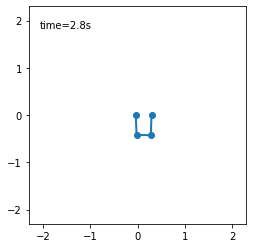

In [40]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt[1] - tt[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*res[i, :res.shape[1]//2])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(res.shape[0]), interval=tt[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())



